# ASTROPI22 - LAZOS22 - Phase 4 : analysis - Notebook

# Importing libs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv
from math import pi, sin, sqrt
import cmath

# Import data from the csv file

In [2]:
date = []
lat = []
lon = []
xstrength = []
ystrength = []
zstrength = []
lum = []

with open('./data.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        try:
            date.append(datetime.datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S.%f"))
            lat.append(float(row[1]))
            lon.append(float(row[2]))
            xstrength.append(float(row[3]))
            ystrength.append(float(row[4]))
            zstrength.append(float(row[5]))
            lum.append(int(row[6]))
        except:
            pass
        
date = np.array(date)
lat = np.array(lat)
lon = np.array(lon)
xstrength = np.array(xstrength)
ystrength = np.array(ystrength)
zstrength = np.array(zstrength)

# Calculating full magnetic strength

$V = \sqrt{V_x^2 + V_y^2 + V_z^2}$ with $V$ the total strength, $V_x$ the strength on the x-axis, and so with $V_y$ and $V_z$

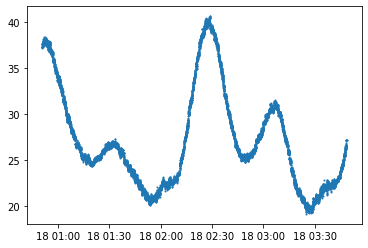

In [3]:
total_strength = np.sqrt(xstrength**2 + ystrength**2 + zstrength**2)
plt.scatter(date, total_strength, s=1)
plt.show()

# Day-Night Cycle

### Calculating the day night function parameters

We can modelize the day/night cycle. It is a function $f(t) = \sin(\omega t + \phi )$. This function is positive when it is day, and negative when it is night. Moreover, we know that at the beginning it is day, and it switch to night at $t_{s_0}$, then from night to day at $t_{s_1}$ and so on with $t_{s_2}$ and $t_{s_3}$. We have a period $T=t_{s_2}-t_{s_0}$. So $\omega = \frac{2 \pi}{T}$. Moreover, we know that at $t_{s_1}$, we pass to day, so $\omega  \cdot t_{s_1} + \phi \equiv 2 \pi \equiv 0 \pmod{2 \pi}$. Therefore, we can assume that $\phi = - \omega \cdot t_{s_1}$.

We have : $f(t) = \sin{\left( \omega \cdot ( t - t_{s_1} ) \right) }$

In [4]:
# Points where it passes from night to day or day to night. Knowing that it is day at the beginning
times_sun_change = ['2022-04-18 01:28:08', '2022-04-18 02:13:20', '2022-04-18 03:01:30', '2022-04-18 03:45:56']
times_sun_change_ = [datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in times_sun_change] # t_{s_i}

# Calculating the period by meaning multiple values
period = 0
for i in range(0, len(times_sun_change_)-2):
    period += (times_sun_change_[i+2] - times_sun_change_[i]).total_seconds()
period /= (len(times_sun_change_)-2)
print("Period of a total day/night cycle : ", period, "seconds")

frequency = 2 * pi / period

day_night_cycle_values =  [sin(frequency * (t - times_sun_change_[1]).total_seconds()) for t in date]

Period of a total day/night cycle :  5579.0 seconds


### Comparison of the period with the theoritcal value

Relative gap $u$. Let $V$ be the experimental value and $V_{th}$ be the experimental one.

$u = \frac{|V_{th}-V|}{V_{th}}$

In [5]:
period_th = 92.68*60
print("relative gap : ", round(100 * (period - period_th)/period_th, 3), "%")

relative gap :  0.327 %


### Plotting the day night cycle

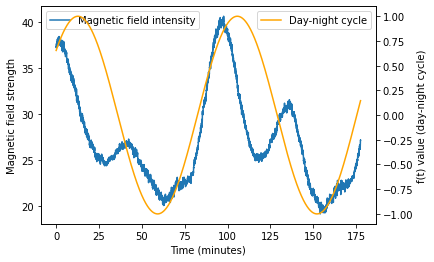

In [6]:
fig, ax1 = plt.subplots()

time_delta = [(date[i] - date[0]).total_seconds()/60 for i in range(0, len(date))] # Time passed in minutes

ax1.plot(time_delta, total_strength, label="Magnetic field intensity")
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Magnetic field strength')

ax2 = ax1.twinx()
ax2.plot(time_delta, day_night_cycle_values, color='orange', label="Day-night cycle")
ax2.set_ylabel('f(t) value (day-night cycle)')

ax1.legend()
ax2.legend()

# plt.show()
plt.savefig("daynightcycle.jpg", dpi=300, bbox_inches='tight')

# Doing a fourier transform

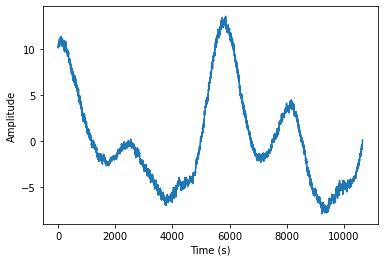

In [7]:
# We center the data to make the fourier tranform easier
total_strength_centered = total_strength - np.mean(total_strength)
times_seconds = [(date[i] - date[0]).total_seconds() for i in range(0, len(date))]

plt.plot(times_seconds, total_strength_centered)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.show()

Let $A$ be the set of the magnetic field strength. $A_i$ be the data at a certain point. And $t_i$ the time where this data as been captured.

Let $v(\omega)$ be the fast fourier function value in function of the frequency 

$\hat{g}(\omega) = \frac{1}{|A|} \cdot \displaystyle\sum_{i=1}^{|A|} A_i \cdot e^{2 \cdot \pi \cdot i \cdot \omega \cdot t_i}$

In [8]:
# Fast Transform function
def fourier (freq, x, date):

    s = 0

    for k in range(0, len(x)):
        dt = (date[k] - date[0])
        v = (x[k] * cmath.exp(2 * pi * 1j * freq * dt))
        s+=v
        
    s/=len(x)
    return (s.real, s.imag)

In [9]:
# /!\ This cell can take a bit of time to run

# Checking with different frequencies
periods = np.linspace(10, 178, 2000) # in minutes
frequencies = 1/(60*periods)
a = []
b = []
for fr in frequencies:
    re, im = fourier(fr, total_strength_centered, times_seconds)
    a.append(re)
    b.append(im)

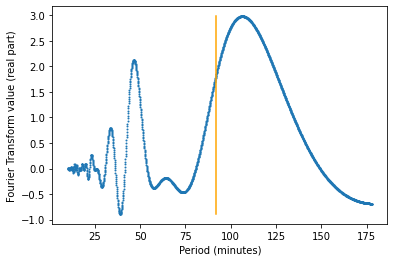

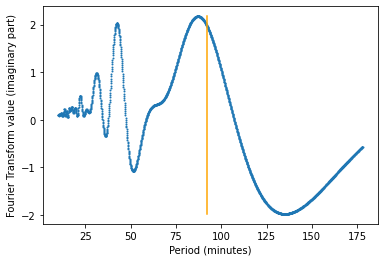

In [10]:
plt.scatter(1/(60*frequencies), a, s=1) # Let's put on the X axis the period checked (simplier than frequency, beause it is very small frequency that we are looking for.
plt.plot([(92), (92)], [min(a), max(a)], c="orange") # Let's do a mark at the frequency of the ISS around the earth.
plt.xlabel("Period (minutes)")
plt.ylabel("Fourier Transform value (real part)")

# plt.show()
plt.savefig("fft_real.jpg", dpi=300, bbox_inches='tight')
plt.show()

plt.scatter(1/(60*frequencies), b, s=1) # Let's put on the X axis the period checked (simplier than frequency, beause it is very small frequency that we are looking for.
plt.plot([(92), (92)], [min(b), max(b)], c="orange") # Let's do a mark at the frequency of the ISS around the earth.
plt.xlabel("Period (minutes)")
plt.ylabel("Fourier Transform value (imaginary part)")

# plt.show()
plt.savefig("fft_imag.jpg", dpi=300, bbox_inches='tight')

# Plotting on a map

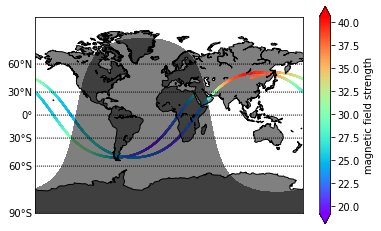

In [11]:
from mpl_toolkits.basemap import Basemap


# miller projection
map = Basemap(projection='mill', lon_0=0)
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])

# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
map.fillcontinents(color='grey')

# Plotting the night zone at the middle of the expriment
CS=map.nightshade(date[int(len(date)/2)])

lon_, lat_ = map(lon, lat)

plt.scatter(lon_, lat_, s=1, c=total_strength, cmap="rainbow")
cbar = plt.colorbar(extend="both")
cbar.set_label(label="magnetic field strength")

# plt.show()
plt.savefig("map.jpg", dpi=300, bbox_inches='tight')

# 3D representation with the ecliptic axis

In a static polar coordinates system :

$\theta=longitude$

$\phi=90-latitude$

$r$ is the distance between the center of the earth and point.

We are tying here to get the cartesian coordinates

By using simple trigonometry formulas we find :
\begin{cases}
x = r \cdot \sin{\phi} \cdot \cos{\theta}\\
y = r \cdot \sin{\phi} \cdot \sin{\theta}\\
z = r \cdot \cos{\phi}\\
\end{cases}

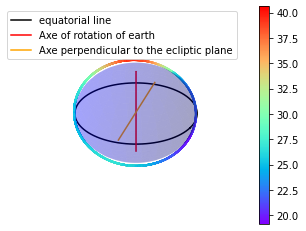

In [12]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Magnetic field captured

phi = (90-lat)*pi/180
thetha = np.array([lon[i] + (360 * times_seconds[i])/(86164.094) for i in range(0, len(xstrength))])*pi/180 # The target is here to oppose the rotation of the earth, as we need a static coordinate system

r = 6371000 # earth radius (m)
x = (r+375000) * np.sin(phi) * np.cos(thetha) # 375000m is the meaned altitude with the surface of earth
y = (r+375000) * np.sin(phi) * np.sin(thetha)
z = (r+375000) * np.cos(phi)

p = ax.scatter(x, y, z, s=1, c=total_strength, cmap="rainbow")
fig.colorbar(p, ax=ax)

# Sphere

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x_sphere = 1 * np.outer(np.cos(u), np.sin(v))
y_sphere = 1 * np.outer(np.sin(u), np.sin(v))
z_sphere = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(r*x_sphere, r*y_sphere, r*z_sphere,  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.2)

# Equatorial line

x_equatorial = r * np.cos(np.linspace(0, 2*pi, 100))
y_equatorial = r * np.sin(np.linspace(0, 2*pi, 100))
z_equatorial = np.linspace(0, 0, 100)

ax.plot(x_equatorial, y_equatorial, z_equatorial, color="black", label="equatorial line")

# Earth rotation axis

ax.plot([0, 0], [0, 0], [r, -r], color="red", label="Axe of rotation of earth")

# Normal to the ecliptic plane

theta_ecliptic = (172/365)*2*pi
phi_ecliptic = -23*pi/180

ax.plot(
    [r * np.sin(phi_ecliptic) * np.cos(theta_ecliptic), -r * np.sin(phi_ecliptic) * np.cos(theta_ecliptic)], 
    [r * np.sin(phi_ecliptic) * np.sin(theta_ecliptic), -r * np.sin(phi_ecliptic) * np.sin(theta_ecliptic)], 
    [r*np.cos(phi_ecliptic), -r * np.cos(phi_ecliptic)], color="orange", label="Axe perpendicular to the ecliptic plane")

ax.set_axis_off()
ax.legend()
plt.show()

# Checking the difference between the two orbit around earth

92.98333333333333
84.60381880000001


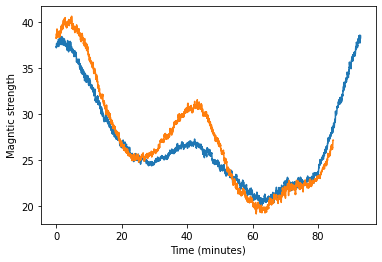

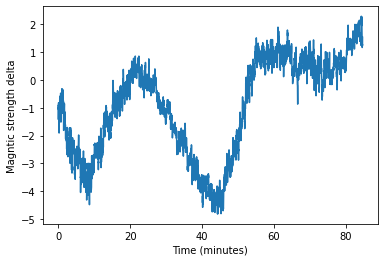

In [13]:
print(period/60)
print(((date[-1]-date[0]).total_seconds()/60)%(period/60))

round1_x=[]
round1_y=[]

round2_x=[]
round2_y=[]

for i in range(0, len(total_strength)):
    if (date[i] - date[0]).total_seconds() <= period:
        round1_x.append((date[i] - date[0]).total_seconds()/60)
        round1_y.append(total_strength[i])
    else:
        round2_x.append(((date[i] - date[0]).total_seconds()-period)/60)
        round2_y.append(total_strength[i])
        
plt.plot(round1_x, round1_y, label="Round 1")
plt.plot(round2_x, round2_y, label="Round 2")
plt.xlabel("Time (minutes)")
plt.ylabel("Magntic strength")
plt.show()

delta = np.array(round1_y[0:len(round2_y)]) - np.array(round2_y)
plt.plot(round2_x, delta)
plt.xlabel("Time (minutes)")
plt.ylabel("Magntic strength delta")
# plt.show()
plt.savefig("delta.jpg", dpi=300, bbox_inches='tight')